In [65]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob
from functools import reduce
import os
import re
from dotenv import load_dotenv
import json
import ast

load_dotenv(override=True)

def normalize_metric_name(name):
    # Removes _per_XX_days (where XX is any number)
    return re.sub(r'_per_\d+_days$', '', name)


RESULTS_DIRECTORY = os.getenv("RESULTS_DIRECTORY")
BUCKET_SIZE = os.getenv("BUCKET_SIZE")
try:
    repositories_to_delete = ast.literal_eval(os.getenv("PARTICIPANTS_TO_REMOVE", ""))
except:
    repositories_to_delete = None

mapping_path = os.getenv('MAPPING_PATH')
# Cast to boolean: True if input is string "True", False if "False", else fallback to False
person_repo = os.getenv("PER_PERSON") == "True"

# mapping_path = f'/Users/annemariewittig/Master/repositoryanalysis/{RESULTS_DIRECTORY.split('/')[-1]}/mapping.json'
person_repo = False
# mapping_path = f'/Users/annemariewittig/Master/repositoryanalysis/{RESULTS_DIRECTORY.split('/')[-1]}/by_person/mapping.json'
# person_repo = True
print(mapping_path)
# Load the mapping JSON
try:
    with open(mapping_path, 'r') as f:
        participant_mapping = json.load(f)

    order_of_repositories = list(participant_mapping[key]['SYNONYM'] for key in participant_mapping.keys() if 'XX' not in participant_mapping[key]['SYNONYM'])
    renaming_dict = {key: participant_mapping[key].get('SYNONYM', key) for key in participant_mapping.keys()}
    renaming_dict
except:
    print("No renaming found, using classic naming")

/Users/annemariewittig/Master/repositoryanalysis/OSR/mapping.json


In [66]:

# Load all CSVs
files = glob(f"{RESULTS_DIRECTORY}/metric_calculation_{BUCKET_SIZE}/*.csv")  # adjust path
frames = []
test_mapping_frames = []
print(f"Found {len(files)} CSV files in {RESULTS_DIRECTORY}/metric_calculation")
print(files)
for file in files:
    metric_raw = file.split("/")[-1].replace(".csv", "")
    metric = normalize_metric_name(metric_raw)
    # print(f"Processing metric: {metric} from file {file}")
    df = pd.read_csv(file)
    
    if repositories_to_delete:
        df = df[~df["repository"].isin(repositories_to_delete)]
    
    if renaming_dict:
        # Rename repositories based on the mapping
        df["repository"] = df["repository"].replace(renaming_dict)
        
    print(file)
    # Extract repository and test_used columns
    test_df = df[["repository", "test_used"]].rename(columns={"test_used": metric})
    test_mapping_frames.append(test_df)

    # Mask non-significant values
    # df.loc[~df["significant"], "effect_size"] = np.nan
    df = df[["repository", "effect_size"]].rename(columns={"effect_size": metric})
    frames.append(df)

# Merge all test mappings into a single DataFrame
test_mapping_combined = reduce(lambda l, r: pd.merge(l, r, on="repository", how="outer"), test_mapping_frames)
test_mapping_combined.set_index("repository", inplace=True)

# Display the test mapping DataFrame
test_mapping_combined

Found 14 CSV files in /Users/annemariewittig/Master/repo-analysis/results/OSR/metric_calculation
['/Users/annemariewittig/Master/repo-analysis/results/OSR/metric_calculation_90/pull_requests_successful_per_90_days.csv', '/Users/annemariewittig/Master/repo-analysis/results/OSR/metric_calculation_90/time_to_merge_into_main_per_90_days.csv', '/Users/annemariewittig/Master/repo-analysis/results/OSR/metric_calculation_90/M1_per_90_days.csv', '/Users/annemariewittig/Master/repo-analysis/results/OSR/metric_calculation_90/commits_loc_deleted_per_90_days.csv', '/Users/annemariewittig/Master/repo-analysis/results/OSR/metric_calculation_90/pull_requests_time_to_merge_per_90_days.csv', '/Users/annemariewittig/Master/repo-analysis/results/OSR/metric_calculation_90/pull_requests_total_per_90_days.csv', '/Users/annemariewittig/Master/repo-analysis/results/OSR/metric_calculation_90/M7_per_90_days.csv', '/Users/annemariewittig/Master/repo-analysis/results/OSR/metric_calculation_90/M2_per_90_days.csv', 

,pull_requests_successful,time_to_merge_into_main,M1,commits_loc_deleted,pull_requests_time_to_merge,pull_requests_total,M7,M2,commits_total,commits_loc_added,commits_loc_changed,commits_coupling,releases,pull_requests_time_to_close
repository,,,,,,,,,,,,,,
BS,Cliff's Delta,Cliff's Delta,Cliff's Delta,Cliff's Delta,Cliff's Delta,Cliff's Delta,Cliff's Delta,Cliff's Delta,Cliff's Delta,Cliff's Delta,Cliff's Delta,Cliff's Delta,Cliff's Delta,Cliff's Delta
FA,Cliff's Delta,Cliff's Delta,Cliff's Delta,Cliff's Delta,Cliff's Delta,Cliff's Delta,Cliff's Delta,Cliff's Delta,Cliff's Delta,Cliff's Delta,Cliff's Delta,Cliff's Delta,Cliff's Delta,Cliff's Delta
GD,Cliff's Delta,Cliff's Delta,Cliff's Delta,Cliff's Delta,Cliff's Delta,Cliff's Delta,Cliff's Delta,Cliff's Delta,Cliff's Delta,Cliff's Delta,Cliff's Delta,Cliff's Delta,Cliff's Delta,Cliff's Delta
GIN,Cliff's Delta,Cliff's Delta,Cliff's Delta,Cliff's Delta,Cliff's Delta,Cliff's Delta,Cliff's Delta,Cliff's Delta,Cliff's Delta,Cliff's Delta,Cliff's Delta,Cliff's Delta,Cliff's Delta,Cliff's Delta
RN,Cliff's Delta,Cliff's Delta,Cliff's Delta,Cliff's Delta,Cliff's Delta,Cliff's Delta,Cliff's Delta,Cliff's Delta,Cliff's Delta,Cliff's Delta,Cliff's Delta,Cliff's Delta,Cliff's Delta,Cliff's Delta
VSC,Cliff's Delta,Cliff's Delta,Cliff's Delta,Cliff's Delta,Cliff's Delta,Cliff's Delta,Cliff's Delta,Cliff's Delta,Cliff's Delta,Cliff's Delta,Cliff's Delta,Cliff's Delta,Cliff's Delta,Cliff's Delta


In [67]:
# Merge on repository
merged_df = reduce(lambda left, right: pd.merge(left, right, on="repository", how="outer"), frames)
merged_df.set_index("repository", inplace=True)

# Rename and reorder
# merged_df.columns = [
#     col.split('_per_')[0]
#     if '_per_' in col else col
#     for col in merged_df.columns
# ]



import json
with open('./metric_mapping.json', 'r') as f:
    metric_mapping = json.load(f)
    
merged_df = merged_df[sorted(merged_df.columns)]
merged_df.to_csv(f"{RESULTS_DIRECTORY}/merged_metrics_{BUCKET_SIZE}.csv")
merged_df

# test_used_mapping

,M1,M2,M7,commits_coupling,commits_loc_added,commits_loc_changed,commits_loc_deleted,commits_total,pull_requests_successful,pull_requests_time_to_close,pull_requests_time_to_merge,pull_requests_total,releases,time_to_merge_into_main
repository,,,,,,,,,,,,,,
BS,-0.289256,0.057851,0.322314,0.157025,-0.553719,-0.504132,-0.190083,-0.884298,-0.851240,-0.685950,-0.057851,-0.884298,-0.396694,-0.278409
FA,-0.173554,0.355372,0.057851,-0.008264,0.735537,0.735537,0.752066,0.735537,0.619835,-0.719008,-0.702479,0.735537,0.256198,-0.215909
GD,0.338843,-0.041322,0.057851,-0.834711,-0.289256,-0.256198,-0.239669,0.330579,0.710744,-0.553719,-0.057851,0.851240,0.289256,-0.232955
GIN,-0.404959,0.008264,-0.148760,0.190083,-0.239669,-0.239669,-0.107438,-0.438017,-0.462810,-0.206612,0.173554,0.033058,-0.338843,-0.017045
RN,0.636364,0.801653,-0.388430,-0.355372,-0.190083,-0.239669,-0.289256,0.834711,1.000000,-0.966942,0.338843,1.000000,0.909091,-0.488636
VSC,0.140496,-0.190083,-0.272727,-0.223140,0.289256,0.223140,0.157025,0.719008,0.950413,-1.000000,-0.983471,0.917355,-0.123967,-0.602273


# Extend with pre and after trends

In [68]:
effect_frames = []
annot_frames = []
magnitude_results = []

for file in files:
    metric = normalize_metric_name(file.split("/")[-1].replace(".csv", ""))
    print(metric)
    df = pd.read_csv(file)
    
    if repositories_to_delete:
        df = df[~df["repository"].isin(repositories_to_delete)]
    if renaming_dict:
        # Rename repositories based on the mapping
        df["repository"] = df["repository"].replace(renaming_dict)


    # Find pre and aft columns
    pre_cols = [col for col in df.columns if col.startswith("pre-")]
    post_cols = [col for col in df.columns if col.startswith("post-")]
    if not post_cols:
        post_cols = [col for col in df.columns if col.startswith("aft-")]
    # Calculate slopes
    x = np.arange(len(pre_cols))  # [0, 1, ..., 15]


    # NaN are dropped for the calculation of the slope 
    def compute_slope(row, cols):
        y = row[cols].values.astype(float)
        x = np.arange(len(y))
        
        # Remove NaN values from both x and y
        valid_indices = ~np.isnan(y)
        x = x[valid_indices]
        y = y[valid_indices]
        
        # Check if there are enough points to calculate a slope
        if len(y) < 2:
            return np.nan  # Not enough data points to calculate a slope
        
        return np.polyfit(x, y, 1)[0]

    df["pre_m"] = df.apply(lambda row: compute_slope(row, pre_cols), axis=1)
    df["post_m"] = df.apply(lambda row: compute_slope(row, post_cols), axis=1)

    # Mask effect size if not significant
    # df.loc[~df["significant"], "effect_size"] = np.nan

    # Build annotation string
    def format_annot(row):
        if pd.isna(row["effect_size"]):
            return ""
        arrow = lambda m: "↑" if m > 0 else ("↓" if m < 0 else "→")
        # Format slopes: round to int if abs > 9999, else 2 decimals
        def fmt_slope(m):
            if pd.isna(m):
                return pd.NA
            if abs(m) > 99.99:
                return f"{int(round(m))}"
            else:
                return f"{m:.2f}"
        return f"{row['effect_size']:.2f}\n{arrow(row['pre_m'])}{fmt_slope(row['pre_m'])}\n{arrow(row['post_m'])}{fmt_slope(row['post_m'])}"

    df["annotation"] = df.apply(format_annot, axis=1)
    
    for _, row in df.iterrows():
        magnitude_results.append({
            "repository": row["repository"],
            "metric": metric,
            "pre_slope": row["pre_m"],
            "post_slope": row["post_m"],
            "pre_magnitude": abs(row["pre_m"]) if not pd.isna(row["pre_m"]) else np.nan,
            "post_magnitude": abs(row["post_m"]) if not pd.isna(row["post_m"]) else np.nan
        })

    # Build final dataframes
    effect_df = df[["repository", "effect_size"]].rename(columns={"effect_size": metric})
    annot_df = df[["repository", "annotation"]].rename(columns={"annotation": metric})
    
    # Append "Avg" repository with empty string for metric
    effect_df = pd.concat([effect_df, pd.DataFrame({"repository": ["Avg"], metric: df["effect_size"].mean()})], ignore_index=True)
    annot_df = pd.concat([annot_df, pd.DataFrame({"repository": ["Avg"], metric: f"{df['effect_size'].mean():.2f}"})], ignore_index=True)

    effect_frames.append(effect_df)
    annot_frames.append(annot_df)
    


pull_requests_successful
time_to_merge_into_main
M1
commits_loc_deleted
pull_requests_time_to_merge
pull_requests_total
M7
M2
commits_total
commits_loc_added
commits_loc_changed
commits_coupling
releases
pull_requests_time_to_close


In [69]:
order_of_repositories

['BS', 'FA', 'GIN', 'GD', 'RN', 'VSC']

In [70]:
# Sort each effect_df and annot_df by the order in order_of_repositories (plus "Avg" at the end)
def sort_by_repo_order(df, repo_order):
    # Get unique repositories in the dataframe
    unique_repos = df["repository"].unique()
    
    # Create ordered list: first the repos in order_of_repositories (if they exist),
    # then any additional repos not in the order, then "Avg" at the end
    ordered_repos = []
    for repo in repo_order:
        if repo in unique_repos:
            ordered_repos.append(repo)
    
    # Add any repos not in the predefined order
    for repo in unique_repos:
        if repo not in repo_order and repo != "Avg":
            ordered_repos.append(repo)
    
    # Ensure "Avg" is always last if it exists
    if "Avg" in unique_repos:
        ordered_repos.append("Avg")
    
    df["repository"] = pd.Categorical(df["repository"], categories=ordered_repos, ordered=True)
    return df.sort_values("repository").reset_index(drop=True)

effect_frames = [sort_by_repo_order(df, order_of_repositories) for df in effect_frames]
annot_frames = [sort_by_repo_order(df, order_of_repositories) for df in annot_frames]

effect_frames[0]

,repository,pull_requests_successful
0,BS,-0.851240
1,FA,0.619835
2,GIN,-0.462810
3,GD,0.710744
4,RN,1.000000
5,VSC,0.950413
6,Avg,0.327824


In [71]:
# Merge all into final matrices
effect_combined = reduce(lambda l, r: pd.merge(l, r, on="repository", how="outer"), effect_frames)
annot_combined = reduce(lambda l, r: pd.merge(l, r, on="repository", how="outer"), annot_frames)

effect_combined.set_index("repository", inplace=True)
annot_combined.set_index("repository", inplace=True)

# # Plot heatmap
# plt.figure(figsize=(12, max(6, 0.3 * len(effect_combined))))

# sns.heatmap(
#     effect_combined,
#     annot=annot_combined,
#     fmt="",
#     cmap="RdYlGn", center=0,
#     linewidths=0.5, linecolor='lightgray',
#     cbar_kws={"label": "Effect Size"}
# )
# plt.title("Effect Sizes with Pre/Post Trend Slopes (↑m | ↓m)")
# plt.xlabel("Metric")
# plt.ylabel("Repository")
# plt.tight_layout()
# plt.show()

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
import pandas as pd

def plot_effect_size_heatmap_grouped(
    effect_t: pd.DataFrame,
    annot_t: pd.DataFrame,
    metric_mapping: dict,
    cmap="RdYlGn",
    figsize=(16, 12),
    title="Effect Sizes before and after tool introduction",
    cage_size = 3,
    writing_width = 5
):
    group_order = ["Commit", "File-Level", "Pull Requests", "Other"]
    width = writing_width
    offset = 2.15

    # Rename and group metrics
    renamed_metrics = []
    metric_groups = {}
    for metric in effect_t.index:
        print(metric)
        if metric in metric_mapping:
            short_name = metric_mapping[metric]["label"]
            group = metric_mapping[metric]["group"]
        else:
            short_name, group = metric, "Other"
        renamed_metrics.append(short_name)
        metric_groups[short_name] = group

    effect = effect_t.copy()
    annot = annot_t.copy()
    effect.index = renamed_metrics
    annot.index = renamed_metrics

    sorted_metrics = sorted(
        effect.index, 
        key=lambda m: (0 if m == "Avg" else 1, group_order.index(metric_groups[m]), m)
)
    effect = effect.loc[sorted_metrics]
    annot = annot.loc[sorted_metrics]

    group_labels = [metric_groups[m] for m in sorted_metrics]
    group_boundaries = []
    prev_group = group_labels[0]
    for idx, group in enumerate(group_labels):
        if group != prev_group:
            group_boundaries.append(idx)
            prev_group = group
    group_boundaries = [0] + group_boundaries + [len(sorted_metrics)]

    # Mask and fill
    mask = effect.isna()
    effect_colored = effect.fillna(0)

    fig, ax = plt.subplots(figsize=figsize)

    sns.heatmap(
        effect_colored,
        cmap=cmap,
        center=0,
        linewidths=0.5,
        linecolor='lightgray',
        cbar_kws={"label": "Effect Size"},
        annot=False,
        ax=ax,
        mask=False,
        vmin=-1, vmax=1
    )

    # Add annotation text
    for y, metric in enumerate(effect.index):
        for x, repo in enumerate(effect.columns):
            if mask.loc[metric, repo]:
                continue
            annotation = annot.loc[metric, repo]
            effect_text, trend_text = annotation.split("\n", 1) if "\n" in annotation else (annotation, "")
            ax.text(x + 0.5, y + 0.35, effect_text, ha='center', va='center', fontsize=9, fontweight='bold')
            ax.text(x + 0.5, y + 0.75, trend_text, ha='center', va='center', fontsize=9, alpha=0.6)

    # Tick label formatting
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    ax.xaxis.set_ticks_position('bottom')

    # Add rectangles around tick labels (x-axis and y-axis)
    fig.canvas.draw()  # Force renderer update

    for i, label in enumerate(ax.get_yticklabels()):
        rect = Rectangle(
            (0, i),
            -cage_size,
            1,
            linewidth=0.5,
            edgecolor='black',
            facecolor='none',
            transform=ax.transData,
            clip_on=False
        )
        ax.add_patch(rect)

    # Group separators (horizontal and vertical)
    for b in group_boundaries[1:-1]:
        ax.hlines(y=b, xmin=0, xmax=len(effect.columns), color='black', linewidth=1.5, clip_on=False)
    ax.vlines(x=1, ymin=0, ymax=len(sorted_metrics), color='black', linewidth=2, clip_on=False)

    # Add group names on y-axis (left) 
    for i in range(len(group_boundaries) - 1):
        start, end = group_boundaries[i], group_boundaries[i + 1]
        group_name = group_labels[start]
        center = (start + end) / 2

        # Y-axis group label (left)
        ax.text(
            -width + offset,
            center,
            group_name,
            rotation=90,
            va='center',
            ha='center',
            fontsize=11,
            clip_on=False
        )
        
    # Add rectangles around x-tick labels (repository names at the bottom)
    for label in ax.get_xticklabels():
        bbox = label.get_window_extent(renderer=fig.canvas.get_renderer())
        bbox_data = bbox.transformed(ax.transData.inverted())
        rect = Rectangle(
            (bbox_data.x0 - 0.42, len(sorted_metrics)),
            1,
            cage_size/2 + 0.2,
            linewidth=0.5,
            edgecolor='black',
            facecolor='none',
            transform=ax.transData,
            clip_on=False
        )
        ax.add_patch(rect)

    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title(title, fontsize=14)
    plt.tight_layout()
    plt.show()


In [73]:
# Transpose the dataframes
effect_t = effect_combined.T
annot_t = annot_combined.T
annot_t.columns = [
    col.split('_per_')[0]
    if '_per_' in col else col
    for col in annot_t.columns
]
# # If working with effect_combined and annot_combined:
annot_t = annot_t.sort_index()
effect_t = effect_t.sort_index()

9
pull_requests_successful
time_to_merge_into_main
M1
commits_loc_deleted
pull_requests_time_to_merge
pull_requests_total
M7
M2
commits_total
commits_loc_added
commits_loc_changed
commits_coupling
releases
pull_requests_time_to_close


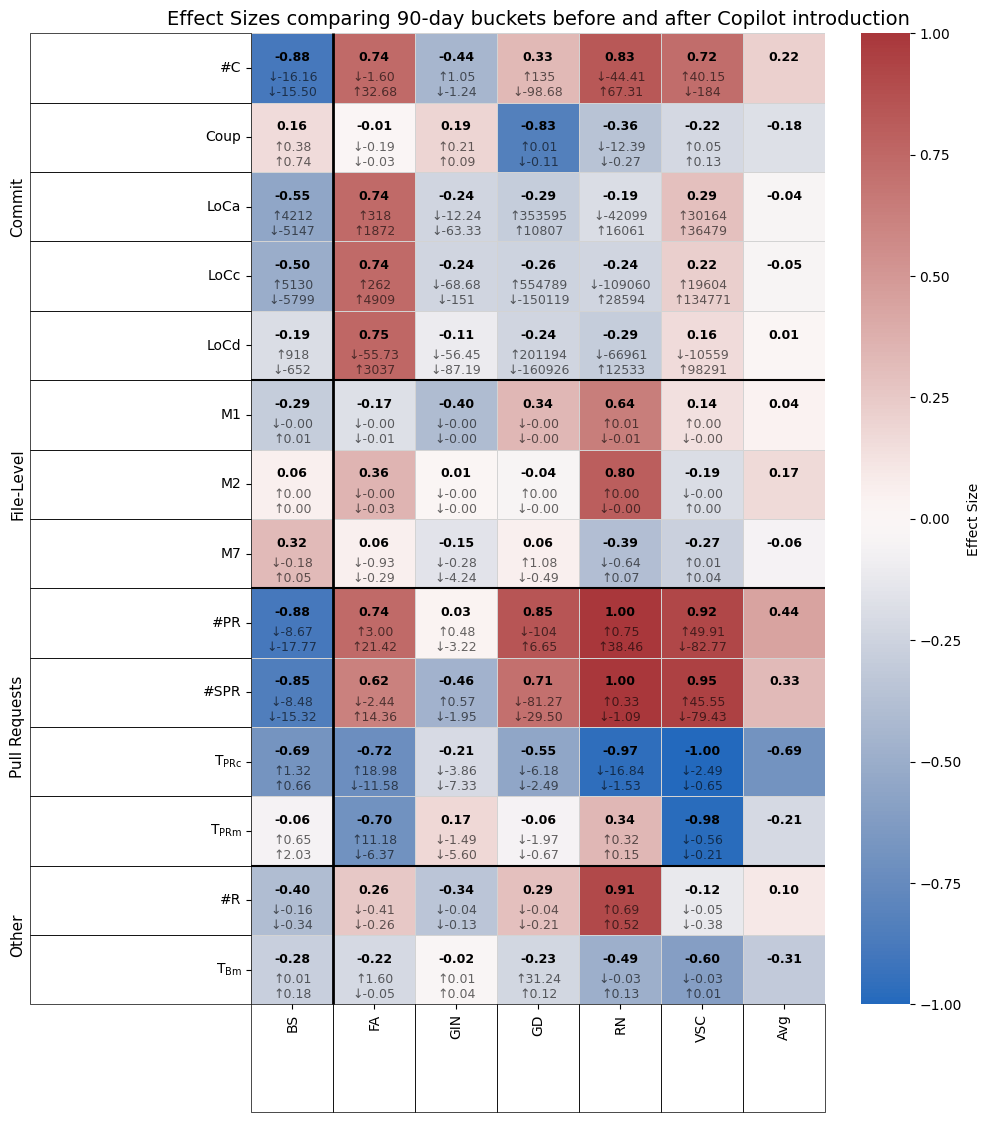

In [74]:
print(len(effect_t.columns)+2)
plot_effect_size_heatmap_grouped(
    effect_t=effect_combined.T,
    annot_t=annot_combined.T,
    metric_mapping=metric_mapping,  # expects dict with keys being raw metric names
    title="Effect Sizes comparing 90-day buckets before and after Copilot introduction",
    figsize=(len(effect_t.columns)+3.1, max(8, 0.8 * len(effect_t))),
    cage_size = 2.7,
    writing_width = 5,
    cmap="vlag"
    # cmap="PiYG_r"
    # cmap="BrBG_r"
    # cmap="PRGn"
    # cmap="RdYlBu_r"
)


In [75]:

import matplotlib.gridspec as gridspec
def plot_effect_size_heatmap_transposed(
    effect_t: pd.DataFrame,
    annot_t: pd.DataFrame,
    metric_mapping: dict,
    cmap="RdYlGn",
    figsize=(16, 12),
    title="Effect Sizes before and after tool introduction",
    cage_size=3,
    writing_width=5,
    title_spacing=0.92,
    fs=12,
    plot_absolute=False,
    rotation=90,
    treat_all_as_average = False,
    hline = -1,
    height_ratios=[0.05, 0.95],
    hspace=0.03
):
    group_order = ["Commit", "File-Level", "Pull Requests", "Other"]
    width = writing_width
    offset = 2.15

    # Transpose for flipping axes
    effect = effect_t.T.copy()
    annot = annot_t.T.copy()

    # Rename and group metrics (now columns after transpose)
    renamed_metrics = []
    metric_groups = {}
    for metric in effect.columns:
        if metric in metric_mapping:
            short_name = metric_mapping[metric]["label"]
            group = metric_mapping[metric]["group"]
        else:
            short_name, group = metric, "Other"
        renamed_metrics.append(short_name)
        metric_groups[short_name] = group

    effect.columns = renamed_metrics
    annot.columns = renamed_metrics

    sorted_metrics = sorted(
        effect.columns, 
        key=lambda m: (0 if m == "Avg" else 1, group_order.index(metric_groups[m]), m)
    )
    effect = effect[sorted_metrics]
    annot = annot[sorted_metrics]
    
    # Add absolute average row to the data
    if "Avg" in effect.index:
        # Calculate absolute average for each metric
        non_average_rows = [i for i in effect.index if i != "Avg"]
        numeric_data = effect.loc[non_average_rows]
        
        # Create absolute average row
        if plot_absolute:
            abs_avg_values = numeric_data.abs().mean()
            abs_avg_annot = abs_avg_values.apply(lambda x: f"{x:.2f}" if pd.notna(x) else "")
            
            # Add the absolute average row to both dataframes
            effect.loc["|Avg|"] = abs_avg_values
            annot.loc["|Avg|"] = abs_avg_annot
        
        # Separate P-numbered repositories and sort them numerically
        p_repos = []
        other_repos = []
        
        for repo in non_average_rows:
            if repo.startswith("P") and repo[1:].isdigit():
                p_repos.append(repo)
            else:
                other_repos.append(repo)
        
        # Sort P-repositories numerically (P1, P2, ..., P9, P10, P11, etc.)
        p_repos.sort(key=lambda x: int(x[1:]))
        
        # Sort other repositories alphabetically
        other_repos.sort()
        
        # Combine: P1-P11..., then others, then Avg, then |Avg|
        if plot_absolute:
            rows = p_repos + other_repos + ["Avg", "|Avg|"]
        else:
            rows = p_repos + other_repos + ["Avg"]
        effect = effect.loc[rows]
        annot = annot.loc[rows]


    group_labels = [metric_groups[m] for m in sorted_metrics]
    group_boundaries = []
    prev_group = group_labels[0]
    for idx, group in enumerate(group_labels):
        if group != prev_group:
            group_boundaries.append(idx)
            prev_group = group
    group_boundaries = [0] + group_boundaries + [len(sorted_metrics)]

    # Mask and fill
    mask = effect.isna()
    effect_colored = effect.fillna(0)


    # Define figure and custom gridspec
    fig = plt.figure(figsize=figsize)

    # Grid: [0] Title (suptitle), [1] Colorbar, [2] Heatmap
    gs = gridspec.GridSpec(nrows=2, ncols=1, height_ratios=height_ratios, hspace=hspace)
    cbar_ax = fig.add_subplot(gs[0])
    ax = fig.add_subplot(gs[1])

    # Title
    fig.suptitle(title, fontsize=fs+4, y=title_spacing)

    # Heatmap with horizontal colorbar
    sns.heatmap(
        effect_colored,
        cmap=cmap,
        center=0,
        linewidths=0.5,
        linecolor='lightgray',
        cbar_kws={"orientation": "horizontal", "label": "Effect Size"},
        cbar_ax=cbar_ax,
        annot=False,
        ax=ax,
        mask=False,
        vmin=-1, vmax=1
    )

    cbar_ax.xaxis.set_label_position('top')
    cbar_ax.xaxis.tick_top()
    cbar_ax.tick_params(labelsize=fs)
    cbar_ax.xaxis.label.set_size(fs)

    # Annotations
    for y, repo in enumerate(effect.index):
        for x, metric in enumerate(effect.columns):
            if mask.loc[repo, metric]:
                continue
            annotation = annot.loc[repo, metric]
            effect_text, trend_text = annotation.split("\n", 1) if "\n" in annotation else (annotation, "")
            
            # Center the text for average rows (no trend data)
            if repo in ["Avg", "|Avg|"] or treat_all_as_average:
                ax.text(x + 0.5, y + 0.5, effect_text, ha='center', va='center', fontsize=fs-2, fontweight='bold')
            else:
                ax.text(x + 0.5, y + 0.35, effect_text, ha='center', va='center', fontsize=fs-2, fontweight='bold')
                ax.text(x + 0.5, y + 0.75, trend_text, ha='center', va='center', fontsize=fs-2, alpha=0.6)

    ax.set_xticklabels(ax.get_xticklabels(), rotation=rotation, ha='center', fontsize=fs)
    ax.tick_params(axis='x', pad=11)  # Add padding between x-axis and x-tick labels
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=fs)
    ax.xaxis.set_ticks_position('bottom')

    fig.canvas.draw()

    # Rectangles on y-tick labels
    for i, label in enumerate(ax.get_yticklabels()):
        rect = Rectangle(
            (0, i),
            -cage_size,
            1,
            linewidth=0.5,
            edgecolor='black',
            facecolor='none',
            transform=ax.transData,
            clip_on=False
        )
        ax.add_patch(rect)

    # Group separators (now vertical)
    for b in group_boundaries[1:-1]:
        ax.vlines(x=b, ymin=0, ymax=len(effect.index) + 1-0.15, color='black', linewidth=1.5, clip_on=False)
    ax.hlines(y=len(effect_t.columns) + hline, xmin=-cage_size, xmax=len(sorted_metrics), color='black', linewidth=1.5, clip_on=False)

    # Group names along x-axis (bottom)
    for i in range(len(group_boundaries) - 1):
        start, end = group_boundaries[i], group_boundaries[i + 1]
        group_name = group_labels[start]
        center = (start + end) / 2
        ax.text(
            center,
            len(effect.index) + 1.2,
            group_name,
            rotation=0,
            va='bottom',
            ha='center',
            fontsize=fs,
            clip_on=False
        )

    # Add rectangles around x-tick labels (repository names at the bottom)
    for i, label in enumerate(ax.get_xticklabels()):
        # Get the position in axis coordinates (0 to 1)
        x = (i + 0.5) / len(ax.get_xticklabels())
        rect = Rectangle(
            (i, len(effect.index)),  # Use i for the column index and len(effect.index) for y position
            1,               # Width of one cell
            2/2 - 0.15,
            linewidth=0.5,
            edgecolor='black',
            facecolor='none',
            transform=ax.transData,  # This is fine if you use integer positions
            clip_on=False
        )
        ax.add_patch(rect)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title("")
    # ax.set_title(title, fontsize=14)
    plt.tight_layout()
    
    if treat_all_as_average:
        plt.savefig(f"./all_averages.pdf", bbox_inches='tight', dpi=300)
    else:
        plt.savefig(f"{RESULTS_DIRECTORY}/metric_calculation_{BUCKET_SIZE}/{RESULTS_DIRECTORY.split('/')[-1]}_visualization.pdf", bbox_inches='tight', dpi=300)
        print(f"Saved heatmap to {RESULTS_DIRECTORY}/metric_calculation_{BUCKET_SIZE}/{RESULTS_DIRECTORY.split('/')[-1]}_visualization.pdf")
    plt.show()


In [76]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colormaps
from matplotlib.colors import to_hex


# 1. Get 'vlag' colormap and extract pure left and right colors
vlag = colormaps["vlag"]
ryb = colormaps["RdYlBu_r"]

print(to_hex(vlag(0)))
print(to_hex(vlag(0.99999999)))
left_color = (70/255, 114/255, 175/255, 1)   # Deep blue
middle_color = (255/255, 244/255, 244/255, 1)
right_color = (189/255, 98/255, 97/255, 1)  # Deep red

print("Left color hex:", to_hex(left_color))
print("Middle color hex:", to_hex(middle_color))
print("Right color hex:", to_hex(right_color))

# 2. Interpolate: left → middle, then middle → right
n_colors = 256
n_half = n_colors // 2
left_to_middle = np.linspace(left_color, middle_color, n_half, endpoint=False)
middle_to_right = np.linspace(middle_color, right_color, n_colors - n_half)
gradient_colors = np.vstack([left_to_middle, middle_to_right])

# 3. Create new colormap
custom_gradient = LinearSegmentedColormap.from_list("custom_vlag_extreme", gradient_colors)

#2369bd
#a9373b
Left color hex: #4672af
Middle color hex: #fff4f4
Right color hex: #bd6261


9
pull_requests_successful
time_to_merge_into_main
M1
commits_loc_deleted
pull_requests_time_to_merge
pull_requests_total
M7
M2
commits_total
commits_loc_added
commits_loc_changed
commits_coupling
releases
pull_requests_time_to_close


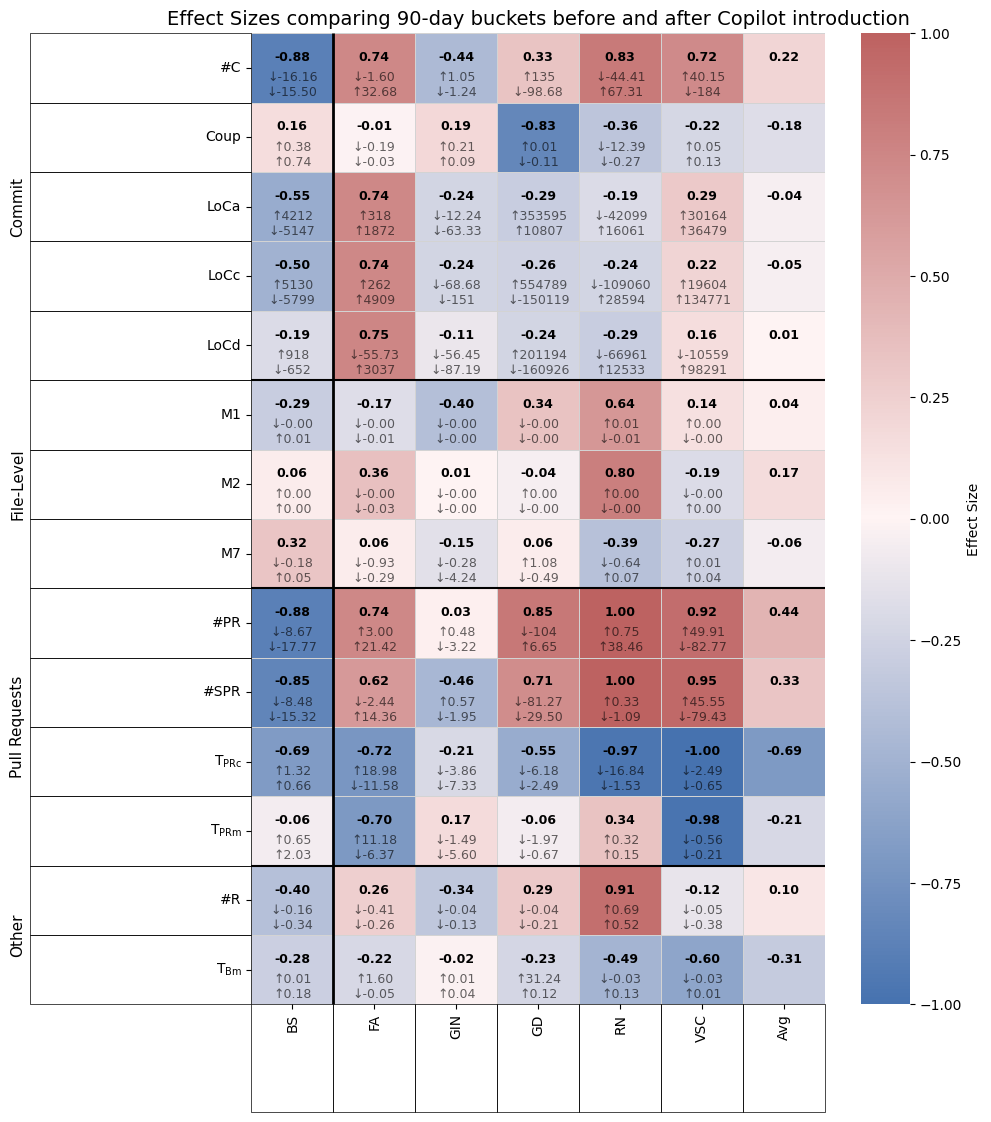

In [77]:
print(len(effect_t.columns)+2)
plot_effect_size_heatmap_grouped(
    effect_t=effect_combined.T,
    annot_t=annot_combined.T,
    metric_mapping=metric_mapping,  # expects dict with keys being raw metric names
    title=f"Effect Sizes comparing {BUCKET_SIZE}-day buckets before and after Copilot introduction",
    figsize=(len(effect_t.columns)+3.1, max(8, 0.8 * len(effect_t))),
    cage_size = 2.7,
    writing_width = 5,
    # cmap="vlag"
    cmap=custom_gradient
    # cmap="PiYG_r"
    # cmap="BrBG_r"
    # cmap="PRGn"
    # cmap="RdYlBu_r"
)

In [78]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colormaps


# 1. Get 'vlag' colormap and extract pure left and right colors
vlag = colormaps["vlag"]
ryb = colormaps["RdYlBu_r"]

left_color = (70/255, 114/255, 175/255, 1)   # Deep blue
middle_color = (255/255, 244/255, 244/255, 1)
right_color = (189/255, 98/255, 97/255, 1)  # Deep red

from matplotlib.colors import to_hex
print("Left color hex:", to_hex(left_color))
print("Middle color hex:", to_hex(middle_color))
print("Right color hex:", to_hex(right_color))

# 2. Interpolate: left → middle, then middle → right
n_colors = 256
n_half = n_colors // 2
left_to_middle = np.linspace(left_color, middle_color, n_half, endpoint=False)
middle_to_right = np.linspace(middle_color, right_color, n_colors - n_half)
gradient_colors = np.vstack([left_to_middle, middle_to_right])

# 3. Create new colormap
custom_gradient = LinearSegmentedColormap.from_list("custom_vlag_extreme", gradient_colors)

Left color hex: #4672af
Middle color hex: #fff4f4
Right color hex: #bd6261


In [79]:
# print(effect_t.columns)
# effect_t = effect_t.drop(columns=["xd8qar3azx", "z1remsbkkq"])
# print(effect_t.columns)

9
CategoricalIndex(['BS', 'FA', 'GIN', 'GD', 'RN', 'VSC', 'Avg'], categories=['BS', 'FA', 'GIN', 'GD', 'RN', 'VSC', 'Avg'], ordered=True, dtype='category', name='repository')
Index(['BS', 'FA', 'GIN', 'GD', 'RN', 'VSC', 'Avg'], dtype='object')


/var/folders/19/fmw641dj3bnfy5qbgqrzmf100000gn/T/ipykernel_62780/2780603033.py:211: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved heatmap to /Users/annemariewittig/Master/repo-analysis/results/OSR/metric_calculation_90/OSR_visualization.pdf


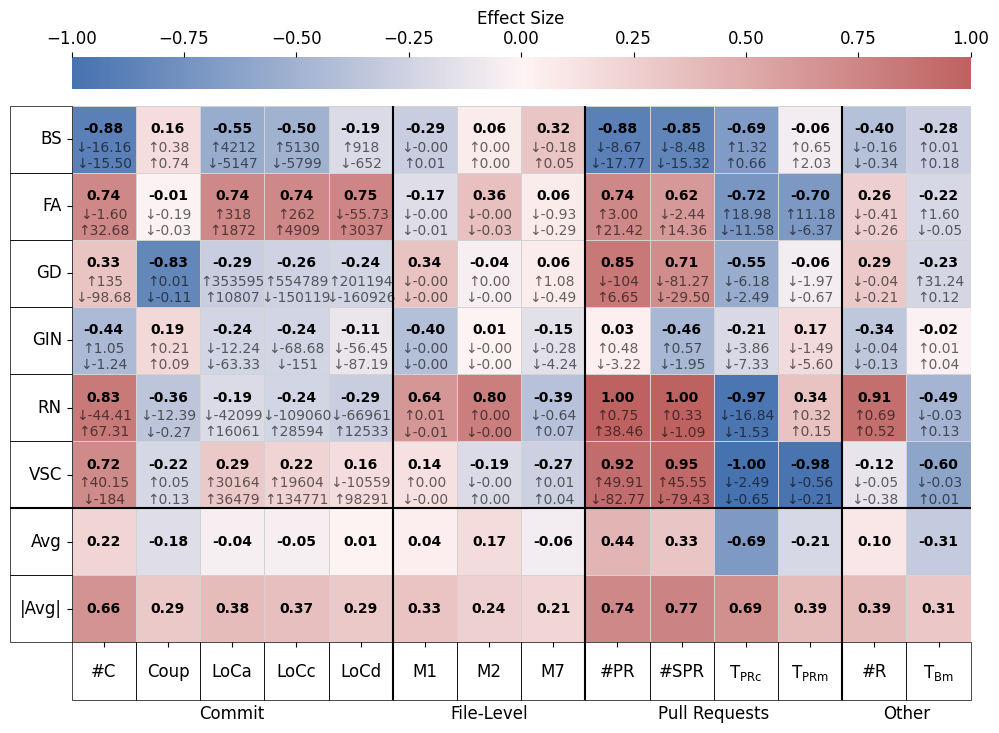

In [80]:
print(len(effect_t.columns)+2)
print(effect_t.columns)
print(annot_t.columns)
plot_effect_size_heatmap_transposed(
    effect_t=effect_combined.T,
    annot_t=annot_combined.T,
    metric_mapping=metric_mapping,  # expects dict with keys being raw metric names
    # title=f"Effect Sizes comparing {BUCKET_SIZE}-day buckets before and after Copilot introduction",
    title="",
    # figsize=(max(8, 0.9 * len(effect_t)), len(effect_t.columns)-4),
    figsize=(max(8, 0.9 * len(effect_t)) -1, len(effect_t.columns)) if person_repo else (max(8, 0.9 * len(effect_t)) -1, len(effect_t.columns) + 0.6), # (width, height).
    cage_size = 0.92 if person_repo else 0.96,
    writing_width = 5,
    cmap=custom_gradient,
    # title_spacing=0.98
    title_spacing=0.98 if person_repo else 0.92,
    plot_absolute=True,
    rotation=0,
    # height_ratios=[0.03,0.97],
    height_ratios=[0.03,0.97] if person_repo else [0.055,0.945],
    hspace=0.03 if person_repo else 0.06
)


In [81]:
merged_df_fin = pd.read_csv(f"{RESULTS_DIRECTORY}/merged_metrics_{BUCKET_SIZE}.csv")
merged_df_fin.columns

Index(['repository', 'M1', 'M2', 'M7', 'commits_coupling', 'commits_loc_added',
       'commits_loc_changed', 'commits_loc_deleted', 'commits_total',
       'pull_requests_successful', 'pull_requests_time_to_close',
       'pull_requests_time_to_merge', 'pull_requests_total', 'releases',
       'time_to_merge_into_main'],
      dtype='object')

In [82]:
# Option 1: assign to a new variable
if person_repo:
	merged_df_fin = merged_df_fin.drop(['releases', 'time_to_merge_into_main'], axis=1)

# If 'repository' is a column, exclude it; otherwise, use all columns
if 'repository' in merged_df_fin.columns:
	numerical_columns = merged_df_fin.columns.drop('repository')
else:
	numerical_columns = merged_df_fin.columns

numerical_columns

Index(['M1', 'M2', 'M7', 'commits_coupling', 'commits_loc_added',
       'commits_loc_changed', 'commits_loc_deleted', 'commits_total',
       'pull_requests_successful', 'pull_requests_time_to_close',
       'pull_requests_time_to_merge', 'pull_requests_total', 'releases',
       'time_to_merge_into_main'],
      dtype='object')

In [83]:
small_effect_boundary = 0.147
middle_effect_boundary = 0.33
large_effect_boundary = 0.474

count_no_effects = 0
count_small_effects = 0
count_middle_effects = 0
count_large_effects = 0

In [84]:
# iterate through rows of the dataframe
for index, row in merged_df_fin.iterrows():
    for col in numerical_columns:
        val = abs(float(row[col]))
        if val > large_effect_boundary:
            count_large_effects += 1
        elif val > middle_effect_boundary:
            count_middle_effects += 1
        elif val > small_effect_boundary:
            count_small_effects +=1
        else:
            count_no_effects += 1

In [85]:
total = count_large_effects + count_middle_effects + count_small_effects + count_no_effects

print(f"Total number of metrics: {total}")
print(f"Number of metrics with no effect: {count_no_effects} ({count_no_effects/total:.2%})")
print(f"Number of metrics with small effect: {count_small_effects} ({count_small_effects/total:.2%})")
print(f"Number of metrics with middle effect: {count_middle_effects} ({count_middle_effects/total:.2%})")
print(f"Number of metrics with large effect: {count_large_effects} ({count_large_effects/total:.2%})")

Total number of metrics: 84
Number of metrics with no effect: 13 (15.48%)
Number of metrics with small effect: 28 (33.33%)
Number of metrics with middle effect: 11 (13.10%)
Number of metrics with large effect: 32 (38.10%)


In [86]:
count_no_effects = 0
count_small_effects_neg = 0
count_middle_effects_neg = 0
count_large_effects_neg = 0
count_small_effects_pos = 0
count_middle_effects_pos = 0
count_large_effects_pos = 0

# iterate through rows of the dataframe
for index, row in merged_df_fin.iterrows():
    for col in numerical_columns:
        val = float(row[col])
        if abs(val) < small_effect_boundary:
            count_no_effects += 1
        elif val > large_effect_boundary:
            count_large_effects_pos += 1
        elif val > middle_effect_boundary:
            count_middle_effects_pos += 1
        elif val > small_effect_boundary:
            count_small_effects_pos +=1
        elif val < -large_effect_boundary:
            count_large_effects_neg += 1
        elif val < -middle_effect_boundary:
            count_middle_effects_neg += 1
        elif val < -small_effect_boundary:
            count_small_effects_neg += 1
        else:
            print(col)
            
# Prepare and print summary output
print("Effect Size Summary (by direction and magnitude):")
print("=" * 50)
total = (
    count_no_effects +
    count_small_effects_neg + count_middle_effects_neg + count_large_effects_neg +
    count_small_effects_pos + count_middle_effects_pos + count_large_effects_pos
)
print(f"Total number of metrics: {total}")
print(f"No effect (|δ| < {small_effect_boundary}): {count_no_effects} ({count_no_effects/total:.1%})")
print(f"Small negative effect: {count_small_effects_neg} ({count_small_effects_neg/total:.1%})")
print(f"Medium negative effect: {count_middle_effects_neg} ({count_middle_effects_neg/total:.1%})")
print(f"Large negative effect: {count_large_effects_neg} ({count_large_effects_neg/total:.1%})")
print(f"Small positive effect: {count_small_effects_pos} ({count_small_effects_pos/total:.1%})")
print(f"Medium positive effect: {count_middle_effects_pos} ({count_middle_effects_pos/total:.1%})")
print(f"Large positive effect: {count_large_effects_pos} ({count_large_effects_pos/total:.1%})")

Effect Size Summary (by direction and magnitude):
Total number of metrics: 84
No effect (|δ| < 0.147): 13 (15.5%)
Small negative effect: 19 (22.6%)
Medium negative effect: 7 (8.3%)
Large negative effect: 15 (17.9%)
Small positive effect: 9 (10.7%)
Medium positive effect: 4 (4.8%)
Large positive effect: 17 (20.2%)


In [87]:
# Direction-aware analysis with magnitude-aware reversals for RQ1
print("=" * 70)
print("DIRECTION-AWARE PRODUCTIVITY TREND ANALYSIS FOR RQ1")
print("=" * 70)
print()

# Categories for enhanced direction-aware analysis
direction_maintained_stronger = 0     # Same direction, larger magnitude
direction_maintained_weaker = 0       # Same direction, smaller magnitude
direction_maintained_similar = 0      # Same direction, similar magnitude
direction_reversed_stronger = 0       # Different directions, larger magnitude
direction_reversed_weaker = 0         # Different directions, smaller magnitude
direction_reversed_similar = 0        # Different directions, similar magnitude
started_trending = 0                  # Was flat, now trending
became_flat = 0                      # Was trending, now flat
both_flat = 0                        # Both flat
no_data_dir = 0                      # Missing data

signed_changes = []  # Store all signed changes for analysis

# Define thresholds
direction_similarity_threshold = 0.2  # 20% for magnitude similarity within same direction
slope_flat_threshold = 1e-6          # Consider slopes near zero as "flat"

print("CATEGORIZATION LOGIC:")
print("=" * 30)
print(f"• Flat threshold: |slope| ≤ {slope_flat_threshold} (effectively zero)")
print(f"• Similar magnitude: within ±{direction_similarity_threshold*100:.0f}% of original")
print(f"• Stronger: post magnitude > pre magnitude")
print(f"• Weaker: post magnitude < pre magnitude")
print(f"• Direction reversal = pre and post slopes have opposite signs")
print()

print("EXAMPLES:")
print("• 1.0 → -1.2: Reversed (stronger)")
print("• 1.0 → -0.8: Reversed (weaker)")  
print("• 1.0 → -0.9: Reversed (similar) - within 20%")
print("• -0.01 → 0.02: Reversed (stronger) - but small magnitudes")
print()


DIRECTION-AWARE PRODUCTIVITY TREND ANALYSIS FOR RQ1

CATEGORIZATION LOGIC:
• Flat threshold: |slope| ≤ 1e-06 (effectively zero)
• Similar magnitude: within ±20% of original
• Stronger: post magnitude > pre magnitude
• Weaker: post magnitude < pre magnitude
• Direction reversal = pre and post slopes have opposite signs

EXAMPLES:
• 1.0 → -1.2: Reversed (stronger)
• 1.0 → -0.8: Reversed (weaker)
• 1.0 → -0.9: Reversed (similar) - within 20%
• -0.01 → 0.02: Reversed (stronger) - but small magnitudes



In [88]:
# Reuse the data from previous analysis
for result in magnitude_results:
    pre_slope = result['pre_slope']
    post_slope = result['post_slope']
    pre_abs = result['pre_magnitude'] 
    post_abs = result['post_magnitude']
    metric = result['metric']
    
    if person_repo and metric in ['releases', 'time_to_merge_into_main']:
        continue
    
    # Calculate signed change for reference
    signed_change = post_slope - pre_slope
    signed_changes.append({
        'repository': result['repository'],
        'metric': result['metric'],
        'pre_slope': pre_slope,
        'post_slope': post_slope,
        'signed_change': signed_change,
        'absolute_change': abs(signed_change)
    })
    
    # Enhanced categorization for Approach 1 (Direction-aware)
    if pd.isna(pre_slope) or pd.isna(post_slope):
        print(f'No data found for {result}')
        no_data_dir += 1
    else:
        # Check if slopes are effectively flat
        pre_flat = abs(pre_slope) <= slope_flat_threshold
        post_flat = abs(post_slope) <= slope_flat_threshold
        
        if pre_flat and post_flat:
            both_flat += 1
        elif pre_flat and not post_flat:
            started_trending += 1
        elif not pre_flat and post_flat:
            became_flat += 1
        else:
            # Both have meaningful slopes - check direction consistency
            same_direction = (pre_slope > 0 and post_slope > 0) or (pre_slope < 0 and post_slope < 0)
            # Same direction - compare magnitudes
            relative_change = abs(post_abs - pre_abs) / pre_abs if pre_abs > 0 else 0
            if relative_change == 0:
                print("shook")
            
            if same_direction:
                if relative_change <= direction_similarity_threshold:
                    direction_maintained_similar += 1
                elif post_abs > pre_abs:
                    direction_maintained_stronger += 1
                else:
                    direction_maintained_weaker += 1
            else:
                if relative_change <= direction_similarity_threshold:
                    direction_reversed_similar += 1
                elif post_abs > pre_abs:
                    direction_reversed_stronger += 1
                else:
                    direction_reversed_weaker += 1


In [89]:

# Results for Enhanced Direction-Aware Analysis
print("ENHANCED DIRECTION-AWARE ANALYSIS RESULTS:")
print("=" * 50)
total_dir = (direction_maintained_stronger + direction_maintained_weaker + 
             direction_maintained_similar + direction_reversed_stronger + direction_reversed_weaker + direction_reversed_similar +
             started_trending + became_flat + both_flat + no_data_dir)

print(f"Direction maintained (stronger):      {direction_maintained_stronger:3d} ({direction_maintained_stronger/total_dir:.1%})")
print(f"Direction maintained (weaker):        {direction_maintained_weaker:3d} ({direction_maintained_weaker/total_dir:.1%})")
print(f"Direction maintained (similar):       {direction_maintained_similar:3d} ({direction_maintained_similar/total_dir:.1%})")
print(f"Direction REVERSED (stronger):        {direction_reversed_stronger:3d} ({direction_reversed_stronger/total_dir:.1%})")
print(f"Direction REVERSED (weaker):          {direction_reversed_weaker:3d} ({direction_reversed_weaker/total_dir:.1%})")
print(f"Direction REVERSED (similar):         {direction_reversed_similar:3d} ({direction_reversed_similar/total_dir:.1%})")
print(f"Started trending (was flat):          {started_trending:3d} ({started_trending/total_dir:.1%})")
print(f"Became flat (was trending):           {became_flat:3d} ({became_flat/total_dir:.1%})")
print(f"Both flat:                            {both_flat:3d} ({both_flat/total_dir:.1%})")
print(f"Missing data:                         {no_data_dir:3d} ({no_data_dir/total_dir:.1%})")
print("-" * 50)
print(f"Total:                                {total_dir:3d}")

print("\nKEY INSIGHTS FOR RQ1:")
print("=" * 30)
maintained_total = direction_maintained_stronger + direction_maintained_weaker + direction_maintained_similar
total_reversals = direction_reversed_stronger + direction_reversed_weaker + direction_reversed_similar
valid_dir = total_dir - no_data_dir

if valid_dir > 0:
    print(f"• Direction reversals (stronger):     {direction_reversed_stronger/valid_dir:.1%} (major productivity increases)")
    print(f"• Direction reversals (weaker):       {direction_reversed_weaker/valid_dir:.1%} (major productivity decreases)")
    print(f"• Direction reversals (similar):      {direction_reversed_similar/valid_dir:.1%} (direction change, same magnitude)")
    print(f"• Total direction reversals:          {total_reversals/valid_dir:.1%}")
    print(f"• Maintained direction:               {maintained_total/valid_dir:.1%}")
    print(f"• Started/stopped trending:           {(started_trending + became_flat)/valid_dir:.1%}")
    print()
    
    print("INTERPRETATION:")
    print("-" * 20)
    if total_reversals > 0:
        print(f"→ {total_reversals} cases show FUNDAMENTAL productivity trajectory changes")
        print("  These represent the most significant AI tool impacts")
    if maintained_total > 0:
        stronger_pct = direction_maintained_stronger / maintained_total * 100
        print(f"→ Of trends that maintained direction, {stronger_pct:.0f}% got stronger")
    
print("\n" + "=" * 70)
print("CONCLUSION FOR RQ1:")
print("AI tool introduction affects repository productivity through:")
print(f"1. Fundamental trajectory changes: {total_reversals} total reversals")
print(f"   - {direction_reversed_stronger} stronger reversals (productivity boost)")
print(f"   - {direction_reversed_weaker} weaker reversals (productivity decline)")
print(f"   - {direction_reversed_similar} similar magnitude reversals")
print(f"2. Trend amplification/dampening: {maintained_total} maintained directions")
print(f"3. Productivity initiation/cessation: {started_trending + became_flat} start/stop cases")
print("=" * 70)

ENHANCED DIRECTION-AWARE ANALYSIS RESULTS:
Direction maintained (stronger):       28 (33.3%)
Direction maintained (weaker):         18 (21.4%)
Direction maintained (similar):         1 (1.2%)
Direction REVERSED (stronger):         16 (19.0%)
Direction REVERSED (weaker):           18 (21.4%)
Direction REVERSED (similar):           3 (3.6%)
Started trending (was flat):            0 (0.0%)
Became flat (was trending):             0 (0.0%)
Both flat:                              0 (0.0%)
Missing data:                           0 (0.0%)
--------------------------------------------------
Total:                                 84

KEY INSIGHTS FOR RQ1:
• Direction reversals (stronger):     19.0% (major productivity increases)
• Direction reversals (weaker):       21.4% (major productivity decreases)
• Direction reversals (similar):      3.6% (direction change, same magnitude)
• Total direction reversals:          44.0%
• Maintained direction:               56.0%
• Started/stopped trending:    

In [90]:
# transform to latex table:

latex_table = f"""
\\begin{{wraptable}}{{r}}{{0.5\\textwidth}}
\\vspace{{-0.5em}}
    \\centering
    \\caption{{Proportion of trend directions maintained or reversed before and after AI tool introduction in the IRs. Similar trends vary by less than 20\\,\\% in magnitude; stronger/weaker trends differ by over 20\\,\\%, regardless of direction.}}
 
    \\label{{tab:slopes}}
    \\begin{{tabular}}{{c||cc}}
    \\toprule
        Direction & Maintained & Reversed \\\\
        \\hline \\hline
        Similar & {direction_maintained_similar:3d} ({direction_maintained_similar/total_dir * 100:.1f}\\,\\%) & {direction_reversed_similar:3d} ({direction_reversed_similar/total_dir * 100:.1f}\\,\\%)\\\\
        Weaker & {direction_maintained_weaker:3d} ({direction_maintained_weaker/total_dir * 100:.1f}\\,\\%) & {direction_reversed_weaker:3d} ({direction_reversed_weaker/total_dir * 100:.1f}\\,\\%) \\\\
        Stronger & {direction_maintained_stronger:3d} ({direction_maintained_stronger/total_dir * 100:.1f}\\,\\%) & {direction_reversed_stronger:3d} ({direction_reversed_stronger/total_dir * 100:.1f}\\,\\%)\\\\
         \\bottomrule
    \\end{{tabular}}
\\end{{wraptable}}
"""

print(latex_table)


\begin{wraptable}{r}{0.5\textwidth}
\vspace{-0.5em}
    \centering
    \caption{Proportion of trend directions maintained or reversed before and after AI tool introduction in the IRs. Similar trends vary by less than 20\,\% in magnitude; stronger/weaker trends differ by over 20\,\%, regardless of direction.}

    \label{tab:slopes}
    \begin{tabular}{c||cc}
    \toprule
        Direction & Maintained & Reversed \\
        \hline \hline
        Similar &   1 (1.2\,\%) &   3 (3.6\,\%)\\
        Weaker &  18 (21.4\,\%) &  18 (21.4\,\%) \\
        Stronger &  28 (33.3\,\%) &  16 (19.0\,\%)\\
         \bottomrule
    \end{tabular}
\end{wraptable}



In [91]:
# Per-participant summary table of effect sizes
# Drop the same excluded columns and analyze effect patterns per repository

# Ensure we have the cleaned dataframe
if ('releases' in merged_df_fin.columns or 'time_to_merge_into_main' in merged_df_fin.columns) and person_repo == True:
    analysis_df = merged_df_fin.drop(['releases', 'time_to_merge_into_main'], axis=1, errors='ignore')
else:
    analysis_df = merged_df_fin.copy()
analysis_df = merged_df_fin.copy()
print(analysis_df.columns)
# Remove the 'repository' column if it exists (since we want it as index)
if 'repository' in analysis_df.columns:
    analysis_df = analysis_df.set_index('repository')

# Define effect size boundaries (same as before)
small_effect_boundary = 0.147

# Initialize results list
participant_results = []

print("Per-Participant Effect Size Analysis:")
print("=" * 60)

# Analyze each repository/participant
for repo in analysis_df.index:
    if repo == "Avg":  # Skip the average row
        continue
        
    row_data = analysis_df.loc[repo]
    
    # Remove NaN values for analysis
    valid_effects = row_data.dropna()
    
    if len(valid_effects) == 0:
        continue
    
    # Count effects by type
    positive_small_plus = sum((valid_effects > small_effect_boundary))
    negative_small_plus = sum((valid_effects < -small_effect_boundary))
    no_effect = sum((abs(valid_effects) <= small_effect_boundary))
    
    # Calculate average effect size
    avg_effect = valid_effects.mean()
    avg_absolute_effect = abs(valid_effects).mean()
    
    # Store results
    participant_results.append({
        'Participant': repo,
        'Positive Effects (≥0.147)': positive_small_plus,
        'Negative Effects (≤-0.147)': negative_small_plus,
        'No Effect (|effect| ≤0.147)': no_effect,
        'Total Metrics': len(valid_effects),
        'Avg Effect Size': avg_effect,
        'Avg |Effect Size|': avg_absolute_effect
    })

# Create DataFrame from results
summary_df = pd.DataFrame(participant_results)

# Sort by participant name (assuming they follow P1, P2, etc. pattern)
def sort_key(participant):
    if participant.startswith('P') and participant[1:].isdigit():
        return int(participant[1:])
    else:
        return float('inf')  # Put non-P participants at the end

summary_df = summary_df.sort_values('Participant', key=lambda x: x.map(sort_key))

# Display the table
print("Summary Table:")
print("-" * 60)
print(summary_df.to_string(index=False, float_format='%.3f'))

print(f"\nOverall Summary:")
print("-" * 30)
total_positive = summary_df['Positive Effects (≥0.147)'].sum()
total_negative = summary_df['Negative Effects (≤-0.147)'].sum()
total_no_effect = summary_df['No Effect (|effect| ≤0.147)'].sum()
total_metrics = summary_df['Total Metrics'].sum()
overall_avg_effect = summary_df['Avg Effect Size'].mean()
overall_avg_abs_effect = summary_df['Avg |Effect Size|'].mean()

print(f"Total positive effects across all participants: {total_positive}")
print(f"Total negative effects across all participants: {total_negative}")
print(f"Total no effects across all participants: {total_no_effect}")
print(f"Total metrics analyzed: {total_metrics}")
print(f"Avg effect size across all participants: {overall_avg_effect:.3f}")
print(f"Avg |effect size| across all participants: {overall_avg_abs_effect:.3f}")

# Calculate percentages
if total_metrics > 0:
    print(f"\nPercentage breakdown:")
    print(f"Positive effects: {total_positive/total_metrics:.1%}")
    print(f"Negative effects: {total_negative/total_metrics:.1%}")
    print(f"No effects: {total_no_effect/total_metrics:.1%}")

# Store the summary for potential further analysis
participant_summary = summary_df


Index(['repository', 'M1', 'M2', 'M7', 'commits_coupling', 'commits_loc_added',
       'commits_loc_changed', 'commits_loc_deleted', 'commits_total',
       'pull_requests_successful', 'pull_requests_time_to_close',
       'pull_requests_time_to_merge', 'pull_requests_total', 'releases',
       'time_to_merge_into_main'],
      dtype='object')
Per-Participant Effect Size Analysis:
Summary Table:
------------------------------------------------------------
Participant  Positive Effects (≥0.147)  Negative Effects (≤-0.147)  No Effect (|effect| ≤0.147)  Total Metrics  Avg Effect Size  Avg |Effect Size|
         BS                          2                          10                            2             14           -0.360              0.437
         FA                          8                           4                            2             14            0.226              0.486
         GD                          5                           6                            3    

In [92]:
# Generate LaTeX table for participant summary
def create_participant_latex_table(df):
    """
    Create a LaTeX table for participant summary with custom formatting
    """
    
    # Create a copy of the dataframe with renamed columns
    latex_df = df.copy()
    
    # Rename columns according to specifications
    latex_df = latex_df.rename(columns={
        'Participant': '',  # Empty header
        'Positive Effects (≥0.147)': '$\\delta \geq 0.147$',
        'Negative Effects (≤-0.147)': '$\\delta \leq -0.147$',
        'No Effect (|effect| ≤0.147)': '$|\\delta| < 0.147$',
        'Avg Effect Size': 'Avg $\\delta$',
        'Avg |Effect Size|': 'Avg $|\\delta|$'
    })
    
    # Remove the 'Total Metrics' column
    if 'Total Metrics' in latex_df.columns:
        latex_df = latex_df.drop('Total Metrics', axis=1)
    
    # Start building LaTeX table
    num_cols = len(latex_df.columns)
    col_spec = 'l' + 'c' * (num_cols - 1)  # Left align first column, center others
    
    latex_table = f"""\\begin{{table}}[h]
\t\\centering
\t\\caption{{Per-participant effect size analysis summary}}
\t\\label{{tab:participant_effect_summary}}
\t\\begin{{tabular}}{{{col_spec}}}
\t\t\\toprule
"""
    
    # Add header row
    headers = latex_df.columns.tolist()
    header_row = ' & '.join(headers) + ' \\\\ \n'
    latex_table += f"\t\t{header_row}"
    latex_table += "\t\t\\midrule\n"
    
    # Add data rows
    for _, row in latex_df.iterrows():
        row_values = []
        for i, value in enumerate(row):
            if i == 0:  # Participant column
                row_values.append(str(value))
            elif isinstance(value, (int, float)):
                row_values.append(f"{int(value)}" if value == int(value) else f"{value:.2f}")
            else:
                row_values.append(str(value))
        
        row_str = ' & '.join(row_values) + ' \\\\ \n'
        latex_table += f"\t\t{row_str}"
    
    # Close table
    latex_table += """\t\t\\bottomrule
\t\\end{tabular}
\\end{table}"""
    
    return latex_table

# Generate the LaTeX table
participant_latex = create_participant_latex_table(participant_summary)

print("LaTeX Table for Participant Summary:")
print("=" * 50)
print(participant_latex)

# Optionally save to file
output_path = f"{RESULTS_DIRECTORY}/participant_effect_summary_table.tex"
with open(output_path, 'w') as f:
    f.write(participant_latex)



print(f"\nLaTeX table saved to: {output_path}")

LaTeX Table for Participant Summary:
\begin{table}[h]
	\centering
	\caption{Per-participant effect size analysis summary}
	\label{tab:participant_effect_summary}
	\begin{tabular}{lccccc}
		\toprule
		 & $\delta \geq 0.147$ & $\delta \leq -0.147$ & $|\delta| < 0.147$ & Avg $\delta$ & Avg $|\delta|$ \\ 
		\midrule
		BS & 2 & 10 & 2 & -0.36 & 0.44 \\ 
		FA & 8 & 4 & 2 & 0.23 & 0.49 \\ 
		GD & 5 & 6 & 3 & 0.01 & 0.36 \\ 
		GIN & 2 & 8 & 4 & -0.16 & 0.21 \\ 
		RN & 7 & 7 & 0 & 0.19 & 0.60 \\ 
		VSC & 6 & 6 & 2 & 0.00 & 0.49 \\ 
		\bottomrule
	\end{tabular}
\end{table}

LaTeX table saved to: /Users/annemariewittig/Master/repo-analysis/results/OSR/participant_effect_summary_table.tex


<>:13: SyntaxWarning: invalid escape sequence '\g'
<>:14: SyntaxWarning: invalid escape sequence '\l'
<>:13: SyntaxWarning: invalid escape sequence '\g'
<>:14: SyntaxWarning: invalid escape sequence '\l'
/var/folders/19/fmw641dj3bnfy5qbgqrzmf100000gn/T/ipykernel_62780/399572922.py:13: SyntaxWarning: invalid escape sequence '\g'
  'Positive Effects (≥0.147)': '$\\delta \geq 0.147$',
/var/folders/19/fmw641dj3bnfy5qbgqrzmf100000gn/T/ipykernel_62780/399572922.py:14: SyntaxWarning: invalid escape sequence '\l'
  'Negative Effects (≤-0.147)': '$\\delta \leq -0.147$',


In [93]:
one_df = pd.read_csv('/Users/annemariewittig/Master/repo-analysis/results/OSR/merged_metrics_90.csv')
two_df = pd.read_csv('/Users/annemariewittig/Master/repo-analysis/results/ITS/merged_metrics_14.csv')

# Compute signed and absolute averages for each dataframe, excluding 'repository' column
osr_signed_avg = one_df.drop(columns=['repository']).mean(axis=0)
osr_abs_avg = one_df.drop(columns=['repository']).abs().mean(axis=0)
ir_signed_avg = two_df.drop(columns=['repository']).mean(axis=0)
ir_abs_avg = two_df.drop(columns=['repository']).abs().mean(axis=0)
# Build new DataFrame with averages as rows and metric names as columns,
# and the average type in the 'repository' column (not as index)
avg_df = pd.DataFrame([
    {"repository": "IR", **ir_signed_avg.to_dict()},
    {"repository": "OSR", **osr_signed_avg.to_dict()},
    {"repository": "|IR|", **ir_abs_avg.to_dict()},
    {"repository": "|OSR|", **osr_abs_avg.to_dict()}
])

avg_df

,repository,M1,M2,M7,commits_coupling,commits_loc_added,commits_loc_changed,commits_loc_deleted,commits_total,pull_requests_successful,pull_requests_time_to_close,pull_requests_time_to_merge,pull_requests_total,releases,time_to_merge_into_main
0,IR,-0.137566,-0.052910,-0.008818,-0.062610,-0.069665,-0.052910,-0.022046,0.020282,-0.178131,0.208995,0.231922,-0.183422,-0.097002,-0.021296
1,OSR,0.041322,0.165289,-0.061983,-0.179063,-0.041322,-0.046832,0.013774,0.216253,0.327824,-0.688705,-0.214876,0.442149,0.099174,-0.305871
2,|IR|,0.246914,0.197531,0.296296,0.346561,0.313051,0.289242,0.284832,0.381834,0.388007,0.327160,0.335979,0.391534,0.238095,0.095370
3,|OSR|,0.330579,0.242424,0.207989,0.294766,0.382920,0.366391,0.289256,0.657025,0.765840,0.688705,0.385675,0.736915,0.385675,0.305871


In [94]:
# Prepare avg_df for visualization (similar to effect_combined structure)
# Set repository as index and transpose for consistent structure
avg_df_viz = avg_df.set_index('repository')

# Create annotation dataframe (just the effect values formatted as strings)
avg_annot_df = avg_df_viz.copy()
for col in avg_annot_df.columns:
    avg_annot_df[col] = avg_annot_df[col].apply(lambda x: f"{x:.2f}" if pd.notna(x) else "")

# Transpose to match the structure expected by the visualization function
avg_effect_t = avg_df_viz.T
avg_annot_t = avg_annot_df.T

print("avg_effect_t shape:", avg_effect_t.shape)
print("avg_annot_t shape:", avg_annot_t.shape)
print("Repositories (columns):", avg_effect_t.columns.tolist())
avg_effect_t

avg_effect_t shape: (14, 4)
avg_annot_t shape: (14, 4)
Repositories (columns): ['IR', 'OSR', '|IR|', '|OSR|']


repository,IR,OSR,|IR|,|OSR|
M1,-0.137566,0.041322,0.246914,0.330579
M2,-0.052910,0.165289,0.197531,0.242424
M7,-0.008818,-0.061983,0.296296,0.207989
commits_coupling,-0.062610,-0.179063,0.346561,0.294766
commits_loc_added,-0.069665,-0.041322,0.313051,0.382920
commits_loc_changed,-0.052910,-0.046832,0.289242,0.366391
commits_loc_deleted,-0.022046,0.013774,0.284832,0.289256
commits_total,0.020282,0.216253,0.381834,0.657025
pull_requests_successful,-0.178131,0.327824,0.388007,0.765840
pull_requests_time_to_close,0.208995,-0.688705,0.327160,0.688705


In [95]:
# import matplotlib.gridspec as gridspec

# def plot_average_heatmap_transposed(
#     effect_t: pd.DataFrame,
#     annot_t: pd.DataFrame,
#     metric_mapping: dict,
#     cmap="RdYlGn",
#     figsize=(16, 12),
#     title="Average Effect Sizes",
#     cage_size=3,
#     writing_width=5,
#     title_spacing=0.92,
#     fs=12,
#     rotation=0
# ):
#     """
#     Plot heatmap for average data where all rows are treated as averages (no trend annotations).
#     Uses the row order as provided in the dataframe.
#     """
#     group_order = ["Commit", "File-Level", "Pull Requests", "Other"]
#     width = writing_width
#     offset = 2.15

#     # Transpose for flipping axes
#     effect = effect_t.T.copy()
#     annot = annot_t.T.copy()

#     # Rename and group metrics (now columns after transpose)
#     renamed_metrics = []
#     metric_groups = {}
#     for metric in effect.columns:
#         if metric in metric_mapping:
#             short_name = metric_mapping[metric]["label"]
#             group = metric_mapping[metric]["group"]
#         else:
#             short_name, group = metric, "Other"
#         renamed_metrics.append(short_name)
#         metric_groups[short_name] = group

#     effect.columns = renamed_metrics
#     annot.columns = renamed_metrics

#     sorted_metrics = sorted(
#         effect.columns, 
#         key=lambda m: (group_order.index(metric_groups[m]), m)
#     )
#     effect = effect[sorted_metrics]
#     annot = annot[sorted_metrics]
    
#     # Keep the row order as provided (no special sorting for averages)
#     # This preserves the order: IR, |IR|, OSR, |OSR|

#     group_labels = [metric_groups[m] for m in sorted_metrics]
#     group_boundaries = []
#     prev_group = group_labels[0]
#     for idx, group in enumerate(group_labels):
#         if group != prev_group:
#             group_boundaries.append(idx)
#             prev_group = group
#     group_boundaries = [0] + group_boundaries + [len(sorted_metrics)]

#     # Mask and fill
#     mask = effect.isna()
#     effect_colored = effect.fillna(0)

#     # Define figure and custom gridspec
#     fig = plt.figure(figsize=figsize)

#     # Grid: [0] Title (suptitle), [1] Colorbar, [2] Heatmap
#     gs = gridspec.GridSpec(nrows=2, ncols=1, height_ratios=[0.05, 0.95], hspace=0.03)
#     cbar_ax = fig.add_subplot(gs[0])
#     ax = fig.add_subplot(gs[1])

#     # Title
#     fig.suptitle(title, fontsize=fs+4, y=title_spacing)

#     # Heatmap with horizontal colorbar
#     sns.heatmap(
#         effect_colored,
#         cmap=cmap,
#         center=0,
#         linewidths=0.5,
#         linecolor='lightgray',
#         cbar_kws={"orientation": "horizontal", "label": "Effect Size"},
#         cbar_ax=cbar_ax,
#         annot=False,
#         ax=ax,
#         mask=False,
#         vmin=-1, vmax=1
#     )

#     cbar_ax.xaxis.set_label_position('top')
#     cbar_ax.xaxis.tick_top()
#     cbar_ax.tick_params(labelsize=fs)
#     cbar_ax.xaxis.label.set_size(fs)

#     # Annotations - all rows treated as averages (centered text, no trend data)
#     for y, repo in enumerate(effect.index):
#         for x, metric in enumerate(effect.columns):
#             if mask.loc[repo, metric]:
#                 continue
#             annotation = annot.loc[repo, metric]
#             # Center the text for all rows (treating all as averages)
#             ax.text(x + 0.5, y + 0.5, annotation, ha='center', va='center', fontsize=fs-1, fontweight='bold')

#     ax.set_xticklabels(ax.get_xticklabels(), rotation=rotation, ha='center', fontsize=fs)
#     ax.tick_params(axis='x', pad=11)  # Add padding between x-axis and x-tick labels
#     ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=fs)
#     ax.xaxis.set_ticks_position('bottom')

#     fig.canvas.draw()

#     # Rectangles on y-tick labels
#     for i, label in enumerate(ax.get_yticklabels()):
#         rect = Rectangle(
#             (0, i),
#             -cage_size,
#             1,
#             linewidth=0.5,
#             edgecolor='black',
#             facecolor='none',
#             transform=ax.transData,
#             clip_on=False
#         )
#         ax.add_patch(rect)

#     # Group separators (now vertical)
#     for b in group_boundaries[1:-1]:
#         ax.vlines(x=b, ymin=0, ymax=len(effect.index) + 1-0.15, color='black', linewidth=1.5, clip_on=False)
#     ax.hlines(y=len(effect.index), xmin=-cage_size, xmax=len(sorted_metrics), color='black', linewidth=1.5, clip_on=False)

#     # Group names along x-axis (bottom)
#     for i in range(len(group_boundaries) - 1):
#         start, end = group_boundaries[i], group_boundaries[i + 1]
#         group_name = group_labels[start]
#         center = (start + end) / 2
#         ax.text(
#             center,
#             len(effect.index) + 1.2,
#             group_name,
#             rotation=0,
#             va='bottom',
#             ha='center',
#             fontsize=fs,
#             clip_on=False
#         )

#     # Add rectangles around x-tick labels (repository names at the bottom)
#     for i, label in enumerate(ax.get_xticklabels()):
#         rect = Rectangle(
#             (i, len(effect.index)),  # Use i for the column index and len(effect.index) for y position
#             1,               # Width of one cell
#             2/2 - 0.15,
#             linewidth=0.5,
#             edgecolor='black',
#             facecolor='none',
#             transform=ax.transData,  
#             clip_on=False
#         )
#         ax.add_patch(rect)
    
#     ax.set_xlabel("")
#     ax.set_ylabel("")
#     ax.set_title("")
#     plt.tight_layout()
    
#     # Save with a different filename for averages
#     plt.savefig(f"{RESULTS_DIRECTORY}/metric_calculation_{BUCKET_SIZE}/averages_comparison_visualization.pdf", bbox_inches='tight', dpi=300)
#     print(f"Saved average comparison heatmap to {RESULTS_DIRECTORY}/metric_calculation_{BUCKET_SIZE}/averages_comparison_visualization.pdf")
#     plt.show()

6
Index(['IR', 'OSR', '|IR|', '|OSR|'], dtype='object', name='repository')
Index(['IR', 'OSR', '|IR|', '|OSR|'], dtype='object', name='repository')


/var/folders/19/fmw641dj3bnfy5qbgqrzmf100000gn/T/ipykernel_62780/2780603033.py:211: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


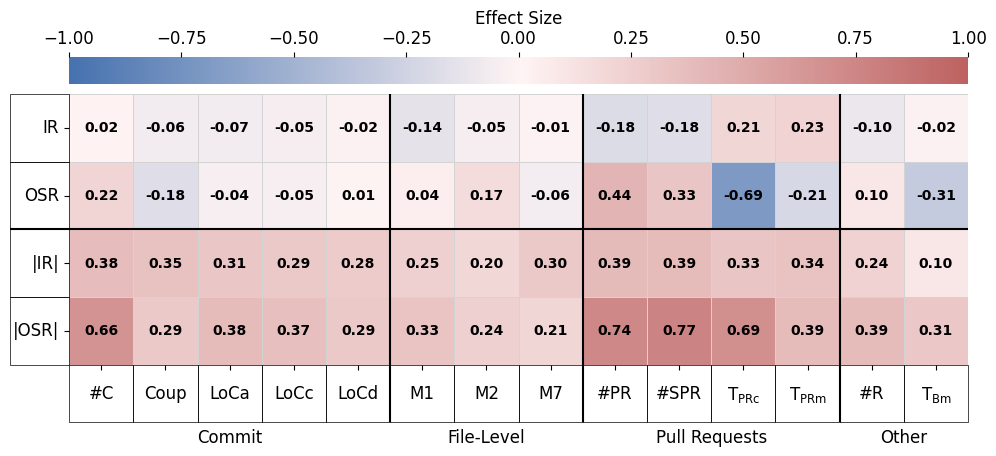

In [96]:
print(len(avg_effect_t.columns)+2)
print(avg_effect_t.columns)
print(avg_annot_t.columns)
plot_effect_size_heatmap_transposed(
    effect_t=avg_effect_t,
    annot_t=avg_annot_t,
    metric_mapping=metric_mapping, # expects dict with keys being raw metric names
    # title=f"Effect Sizes comparing {BUCKET_SIZE}-day buckets before and after Copilot introduction",
    title="",
    # figsize=(max(8, 0.9 * len(effect_t)), len(effect_t.columns)-4),
    figsize=(max(8, 0.9 * len(avg_effect_t)) -1, len(avg_effect_t.columns)),
    cage_size = 0.92,
    writing_width = 5,
    cmap=custom_gradient,
    title_spacing=0.92,
    plot_absolute=True,
    rotation=0,
    treat_all_as_average = True,
    hline=-2,
    height_ratios=[0.09,0.91],
    hspace=0.07
)